# Survival Analysis in Python

SEER Survival Data

Allen B. Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

import utils
from utils import decorate
from empiricaldist import Pmf, Cdf, Surv, Hazard


```
Data is in the SEER directory; cannot be redistributed.

Surveillance, Epidemiology, and End Results (SEER) Program
     (www.seer.cancer.gov) Research Data (1975-2016), National Cancer
     Institute, DCCPS, Surveillance Research Program,
     released April 2019, based on the November 2018 submission.
     
Documentation is in
/INCIDENCE/TEXTDATA.FILEDESCRIPTION.PDF 

Sub-directories with the SEER November 2018 Research Data files.  The
     SEER November 2018 data within each sub-directory have been broken out
     into nine site group files.  The split into site files was made using the 
     Site recode ICD-O-3/WHO 2008.  These files are stored as ASCII text files.

     BREAST.TXT    -  Breast
     COLRECT.TXT   -  Colon and Rectum
     DIGOTHR.TXT   -  Other Digestive
     FEMGEN.TXT    -  Female Genital
     LYMYLEUK.TXT  -  Lymphoma of All Sites and Leukemia
     MALEGEN.TXT   -  Male Genital
     RESPIR.TXT    -  Respiratory
     URINARY.TXT   -  Urinary
     OTHER.TXT     -  All Other Sites


YR1975_2016.SEER9
        This directory contains the SEER November 2018 Research Data files
        from nine SEER registries for 1975-2016.  The SEER 9 registries are
        Atlanta, Connecticut, Detroit, Hawaii, Iowa,  New Mexico, San
        Francisco-Oakland, Seattle-Puget Sound, and Utah.  Data are available
        for cases diagnosed from 1975 and later for these registries.
```


In [2]:
    
names = ['SEX', 'AGE_DX', 'SEQ_NUM', 'YEAR_DX', 'PRIMSITE', 'GRADE', 
         'HISTREC', 'HISTRECB', 'cs0204schema',
         'STAT_REC', 'SRV_TIME_MON', 'SRV_TIME_MON_FLAG']
    
colspecs = [(24-1, 24),   # SEX
            (25-1, 27),   # AGE_DX
            (35-1, 36),   # Sequence number
            (39-1, 42),   # YEAR_DX
            (43-1, 46),   # PRIMSITE
            (58-1, 58),   # GRADE
            (226-1, 227),   # HISTREC
            (228-1, 229),   # HISTRECB
            (230-1, 232), # cs0204schema
            (265-1, 265), # Vital status recode
            (301-1, 304), # Survival months
            (305-1, 305), # Survival months flag
           ]

In [3]:
len(names), len(colspecs)

(12, 12)

```
SEX: 1 male, 2 female

AGE: 999 = unknown

Sequence number: Probably select code 00 = One primary only in the patient’s lifetime

Primary site: This data item identifies the site in which the primary tumor originated. See
the International Classification of Diseases for Oncology, Third Edition
(ICD-O-3) for topography codes. The decimal point is eliminated.

GRADE: Grading and differentiation codes of 1-4, 9 are defined in ICD-O-2; 1992. Grade
information may be incomplete for cases diagnosed before 1977.

Vital status recode: Vital status recode (study cutoff used) Any patient that dies after the follow-up cut-off date is recoded to alive as of the cut-off date.

1 alive, 0 dead

CS SCHEMA
063 Lung


HISTREC: Histology recode broad groupings: 

42: 9670-9699 : nhl - mature b-cell lymphomas
43: 9700-9719 : nhl - mature t and nk-cell lymphomas
44: 9720-9729 : nhl - precursor cell lymphoblastic lymphoma


HISTRECB: Histology recode brain groupings: 
3 = Glioblastoma
11 = Astrocytoma, NOS
12 = Glioma , NOS

Survival months: 

9999 = Unknown

Created using complete dates, including days, therefore may differ from
survival time calculated from year and month only. For more information,
see http://seer.cancer.gov/survivaltime.


Survival months flag

Code
0   Complete dates are available and there are 0 days of survival
1   Complete dates are available and there are more than 0 days of survival
2   Incomplete dates are available and there could be zero days of follow-up
3   Incomplete dates are available and there cannot be zero days of follow-up
9   Unknown

```

In [4]:
def read_seer(dat_file):
    return pd.read_fwf(dat_file,
                     colspecs=colspecs,
                     names=names,
                     header=None,
                     #nrows=10000,
                     #compression='gzip'
                    )

In [5]:
dat_file = 'SEER/SEER_1975_2016_TEXTDATA/incidence/yr1975_2016.seer9/OTHER.TXT'
df = read_seer(dat_file)

In [6]:
df.shape

(900955, 12)

In [7]:
df.head()

,SEX,AGE_DX,SEQ_NUM,YEAR_DX,PRIMSITE,GRADE,HISTREC,HISTRECB,cs0204schema,STAT_REC,SRV_TIME_MON,SRV_TIME_MON_FLAG
0,2,71,2,1980,C809,9,5,98,48,0,79,1
1,1,79,2,1978,C809,9,5,98,48,0,15,1
2,1,86,2,1980,C492,9,28,98,50,0,19,1
3,1,60,4,1990,C809,9,5,98,48,0,6,1
4,2,82,2,1982,C019,1,2,98,148,0,3,1


In [8]:
df['STAT_REC'].value_counts()

1    452101
0    448854
Name: STAT_REC, dtype: int64

In [9]:
df['PRIMSITE'].value_counts()

C809    95433
C445    93532
C739    92988
C446    75408
C447    55173
        ...  
C186        1
C251        1
C574        1
C318        1
C178        1
Name: PRIMSITE, Length: 262, dtype: int64

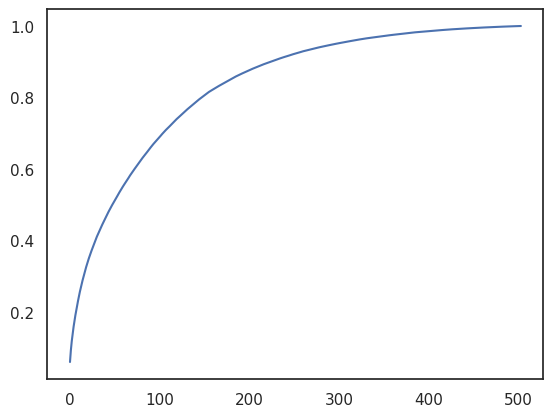

In [10]:
df['SRV_TIME_MON'].replace(9999, np.nan, inplace=True)
Cdf.from_seq(df['SRV_TIME_MON']).plot()

In [11]:
df['SRV_TIME_MON'].describe()

count    889348.000000
mean         84.242866
std          97.402762
min           0.000000
25%          11.000000
50%          48.000000
75%         124.000000
max         503.000000
Name: SRV_TIME_MON, dtype: float64

In [12]:
brain = df['PRIMSITE'].str.startswith('C71')
brain.sum()

70343

In [13]:
df[brain]['HISTRECB'].value_counts().head(5)

3     30749
11     8862
12     4384
2      4220
27     3556
Name: HISTRECB, dtype: int64

In [14]:
top3 = df['HISTRECB'].isin([3, 11, 12])
top3.sum()

44949

In [15]:
(brain&top3).sum()

43995

In [16]:
df[top3]['STAT_REC'].value_counts()

0    39671
1     5278
Name: STAT_REC, dtype: int64

In [17]:
df[brain&top3]['YEAR_DX'].value_counts()

2015    1398
2016    1376
2014    1305
2013    1299
2012    1278
2011    1268
2009    1204
2010    1189
2008    1183
2005    1157
2007    1154
2004    1151
2003    1093
2006    1077
1999    1060
2002    1036
1985    1035
1987    1035
1986    1023
2000    1022
1997    1005
1990    1005
1989    1004
1988    1003
1992    1002
2001    1001
1993     993
1991     993
1996     989
1994     978
1983     949
1981     942
1995     934
1998     933
1980     915
1982     912
1984     908
1979     901
1978     847
1977     844
1975     806
1976     788
Name: YEAR_DX, dtype: int64

In [18]:
df[top3]['SRV_TIME_MON_FLAG'].value_counts()

1    33569
3    10203
8      615
2      475
0       87
Name: SRV_TIME_MON_FLAG, dtype: int64

In [19]:
flag1 = df['SRV_TIME_MON_FLAG'] == 1
flag2 = df['SRV_TIME_MON_FLAG'] == 2

In [20]:
df[top3 & flag2]['SRV_TIME_MON'].value_counts()

0.0    456
3.0      5
5.0      5
1.0      4
2.0      3
4.0      1
6.0      1
Name: SRV_TIME_MON, dtype: int64

In [21]:
subset = df[top3].dropna(subset=['SRV_TIME_MON'])
len(subset)

44334

In [22]:
subset.to_hdf('brain.hd5', 'brain')

In [23]:
brain = pd.read_hdf('brain.hd5', 'brain')
brain.shape

(44334, 12)

In [24]:
brain.head()

,SEX,AGE_DX,SEQ_NUM,YEAR_DX,PRIMSITE,GRADE,HISTREC,HISTRECB,cs0204schema,STAT_REC,SRV_TIME_MON,SRV_TIME_MON_FLAG
30,2,81,2,2001,C713,4,35,3,12,0,1.0,1
32,2,74,2,1979,C713,9,35,3,12,0,2.0,1
35,1,64,0,1981,C718,9,35,3,12,0,1.0,1
38,1,73,2,1982,C718,2,35,11,12,0,5.0,1
63,2,72,0,1979,C718,9,35,3,12,0,2.0,1


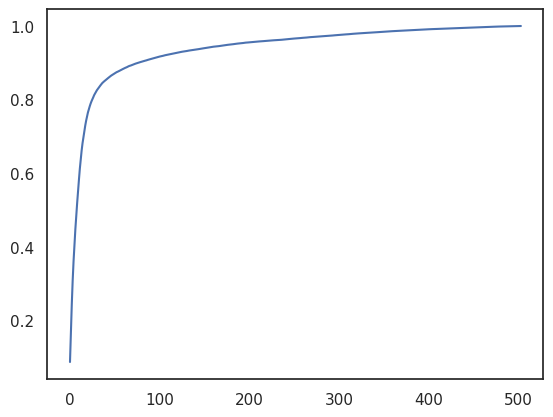

In [25]:
Cdf.from_seq(brain['SRV_TIME_MON']).plot()

## Synthesize data


In [26]:
brain.shape

(44334, 12)

In [27]:
grouped = brain.groupby("HISTRECB")
for name, group in grouped:
    print(name, len(group))

3 30549
11 9006
12 4779


In [28]:
group = grouped.get_group(3)

valid = group["SRV_TIME_MON_FLAG"].isin([1, 3])
valid.sum()

30171

In [29]:
recent = group["YEAR_DX"] >= 2000
recent.sum()

16298

In [30]:
(~recent).sum()

14251

In [31]:
(~recent & valid).sum()

13969

In [32]:
selected = valid & recent
selected.sum()

16202

In [33]:
group.loc[selected, "YEAR_DX"].max()

2016

In [34]:
observed = group.loc[selected, "STAT_REC"] == 0
observed.sum()

14508

In [35]:
duration = group.loc[selected, "SRV_TIME_MON"]
duration.describe()

count    16202.000000
mean        12.794964
std         18.950917
min          0.000000
25%          2.000000
50%          7.000000
75%         16.000000
max        201.000000
Name: SRV_TIME_MON, dtype: float64

In [36]:
def add_jitter(duration, denom=4):
    jitter = np.random.randint(1, denom, len(duration)) / denom
    return duration + jitter

In [38]:
d = dict(duration=duration, observed=observed)
synth = pd.DataFrame(d).sample(frac=1, replace=True).reset_index(drop=True)
synth.head()

,duration,observed
0,4.0,True
1,15.0,True
2,10.0,True
3,6.0,True
4,29.0,True


In [40]:
synth['duration'] = add_jitter(synth['duration'])
synth.head()

,duration,observed
0,4.50,True
1,15.75,True
2,10.75,True
3,6.25,True
4,29.50,True


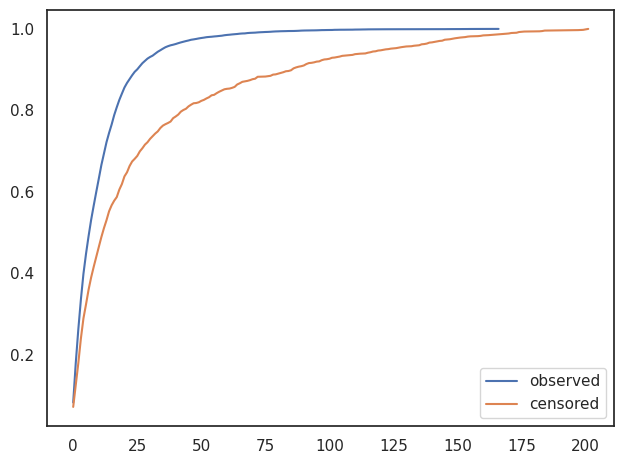

In [41]:
Cdf.from_seq(duration[observed]).plot(label="observed")
Cdf.from_seq(duration[~observed]).plot(label="censored")

decorate(xscale="linear")

In [42]:
synth.to_hdf('brain.hdf', 'brain')